<a href="https://colab.research.google.com/github/bhgtankita/BERT/blob/main/BERT_Ham_Spam_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning BERT for Text Classification

BERT - Bidirectional Encoder Representations from Transformers

* Below are the 2 ways BERT like models can be leveraged:

1. Feature-based approach
  - Downaload a pre-trained BERT model
  - Use BERT to turn natural loaguage sentences into a vector representation
  - Feed the pre-trained vector representations into a model for a downstream task (such as text classification)

2. Perform fine-tuning
  - Download a pre-trained BERT model
  - Update the model weights on the downstream task

* Here we are following the fine-tuning approach on binary text classification.

In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from tqdm import trange
from tabulate import tabulate
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification

import random
import warnings
warnings.filterwarnings("ignore")

In [ ]:
torch.__version__

'2.0.0+cu118'

In [ ]:
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'

--2023-04-28 17:59:32--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K  --.-KB/s    in 0.08s   

2023-04-28 17:59:33 (2.41 MB/s) - ‘smsspamcollection.zip’ saved [203415/203415]



In [ ]:
!unzip -o smsspamcollection.zip

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [ ]:
!head -10 SMSSpamCollection

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
ham	Ok lar... Joking wif u oni...
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
ham	U dun say so early hor... U c already then say...
ham	Nah I don't think he goes to usf, he lives around here though
spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
ham	Even my brother is not like to speak with me. They treat me like aids patent.
ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
spam	H

In [ ]:
def read_data(filepath):
  df = pd.DataFrame({
      'label':int(),
      'text':str()},
      index = []
  )

  with open(filepath) as f:
    for line in f.readlines():
      split = line.split('\t')
      df = df.append({
          'label': 1 if split[0] == 'spam' else 0,
          'text': split[1]
          },
          ignore_index=True
      )
  return df


In [ ]:
filepath = '/content/SMSSpamCollection'
df = read_data(filepath)
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...\n
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
text = df.text.values
labels = df.label.values

# Preprocessing

BERT requires following preprocessing steps:

1. Add special tokens:
  - [CLS]: at the beggining of each sentence (ID 101)
  - [SEP]: at the end of each sentence (ID 102)

2. Make sentences of the same length:
  - This is achieved by padding, i.e. adding values of convenience to shorter sequences to match the desired length. Longer sequences are truncated
  -The padding ([PAD]) tokens have ID 0
  - The maximum sequence length allowed is of 512 tokens

3. Create an attention mask
  - List of 0/1 indicating whether the model should consider tokens or not when learning their contextual representation. We expect [PAD] tokens to have value 0.

* All these steps will be performed with the help of tokenizer.encode_plus method.
* When called, it returns a transformers.tokenization.tokenization-utils_base.BatchEncoding object with the following fields.

  - input_ids: list of token IDs
  - token_type_ids: list of token type ids
  - attention_mask: list of 0/1 indicating which tokens should be considered by the model (return_attention_mask = True)

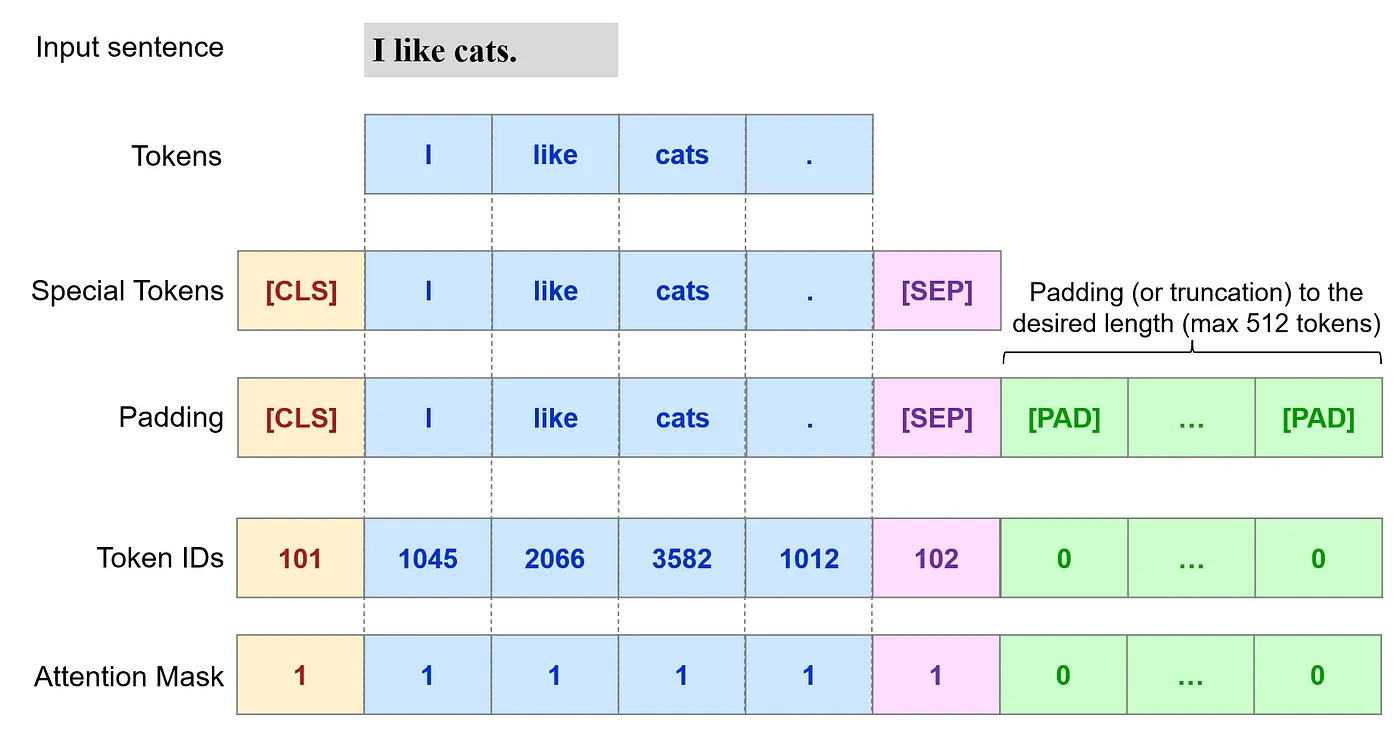

In [ ]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

In [ ]:
def print_rand_sentence():
  
  '''display the tokens and respective ids of a random text sample'''
  index = random.randint(0, len(text)-1)
  table = np.array([
      tokenizer.tokenize(text[index]),
      tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[index]))]).T
  print(tabulate(
      table,
      headers=['Tokens', 'Token IDs'],
      tablefmt='fancy_grid'))

print_rand_sentence()

╒═══════════╤═════════════╕
│ Tokens    │   Token IDs │
╞═══════════╪═════════════╡
│ only      │        2069 │
├───────────┼─────────────┤
│ 2         │        1016 │
├───────────┼─────────────┤
│ %         │        1003 │
├───────────┼─────────────┤
│ students  │        2493 │
├───────────┼─────────────┤
│ solved    │       13332 │
├───────────┼─────────────┤
│ this      │        2023 │
├───────────┼─────────────┤
│ cat       │        4937 │
├───────────┼─────────────┤
│ question  │        3160 │
├───────────┼─────────────┤
│ in        │        1999 │
├───────────┼─────────────┤
│ '         │        1005 │
├───────────┼─────────────┤
│ x         │        1060 │
├───────────┼─────────────┤
│ ##am      │        3286 │
├───────────┼─────────────┤
│ .         │        1012 │
├───────────┼─────────────┤
│ .         │        1012 │
├───────────┼─────────────┤
│ .         │        1012 │
├───────────┼─────────────┤
│ 5         │        1019 │
├───────────┼─────────────┤
│ +         │       

In [ ]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_masks: list of indices (0,1) specifying which tokens should considered by the model (return attention_mask = True)
  '''

  return tokenizer.encode_plus(
      input_text,
      add_special_tokens=True,
      max_length=32,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt'
  )

for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids'])
  attention_masks.append(encoding_dict['attention_mask'])

token_id = torch.cat(token_id, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [ ]:
# ## delete
# print(token_id[7].shape)
# token_id = torch.cat(token_id, dim=0)
# print(token_id[7].shape)

torch.Size([1, 32])
torch.Size([32])


In [ ]:
token_id[6]

tensor([ 101, 2130, 2026, 2567, 2003, 2025, 2066, 2000, 3713, 2007, 2033, 1012,
        2027, 7438, 2033, 2066, 8387, 7353, 1012,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
attention_masks[6]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

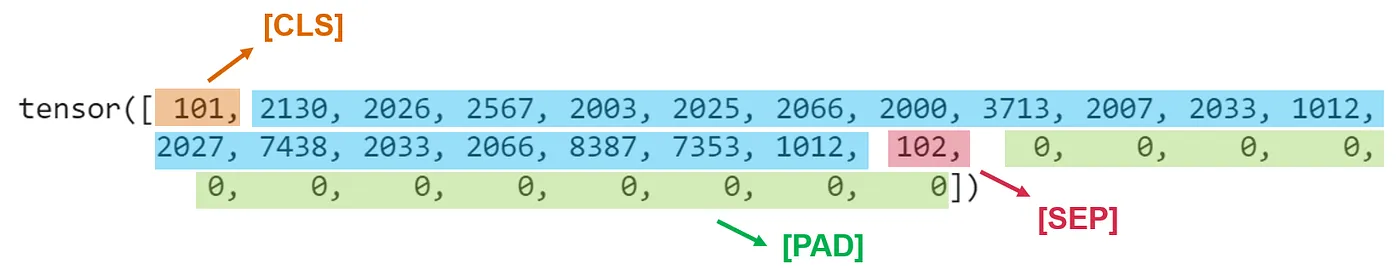

In [ ]:
def print_rand_sentence_encoding():
  '''
  Displays tokens, token Ids and attention mask of a random text sample
  '''

  index = random.randint(0, len(text)-1)
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
  token_ids = [i.numpy() for i in token_id[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(tabulate(
      table,
      headers = ['Tokens', 'Token IDs', 'Attention Mask'],
      tablefmt = 'fancy_grid'
  ))

print_rand_sentence_encoding()

╒══════════╤═════════════╤══════════════════╕
│ Tokens   │   Token IDs │   Attention Mask │
╞══════════╪═════════════╪══════════════════╡
│ [CLS]    │         101 │                1 │
├──────────┼─────────────┼──────────────────┤
│ are      │        2024 │                1 │
├──────────┼─────────────┼──────────────────┤
│ you      │        2017 │                1 │
├──────────┼─────────────┼──────────────────┤
│ staying  │        6595 │                1 │
├──────────┼─────────────┼──────────────────┤
│ in       │        1999 │                1 │
├──────────┼─────────────┼──────────────────┤
│ town     │        2237 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ?        │        1029 │                1 │
├──────────┼─────────────┼──────────────────┤
│ [SEP]    │         102 │                1 │
├──────────┼─────────────┼──────────────────┤
│ [PAD]    │           0 │                0 │
├──────────┼─────────────┼──────────────────┤
│ [PAD]    │           0 │        

In [ ]:
val_ratio = 0.2
batch_size = 16

train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels
)

train_set = TensorDataset(
    token_id[train_idx],
    attention_masks[train_idx], 
    labels[train_idx]
)

val_set = TensorDataset(
    token_id[val_idx],
    attention_masks[val_idx],
    labels[val_idx]
)

train_dataloader = DataLoader(
    train_set,
    sampler = RandomSampler(train_set),
    batch_size = batch_size
)

validation_dataloader = DataLoader(
    val_set,
    sampler = SequentialSampler(val_set),
    batch_size = batch_size
)

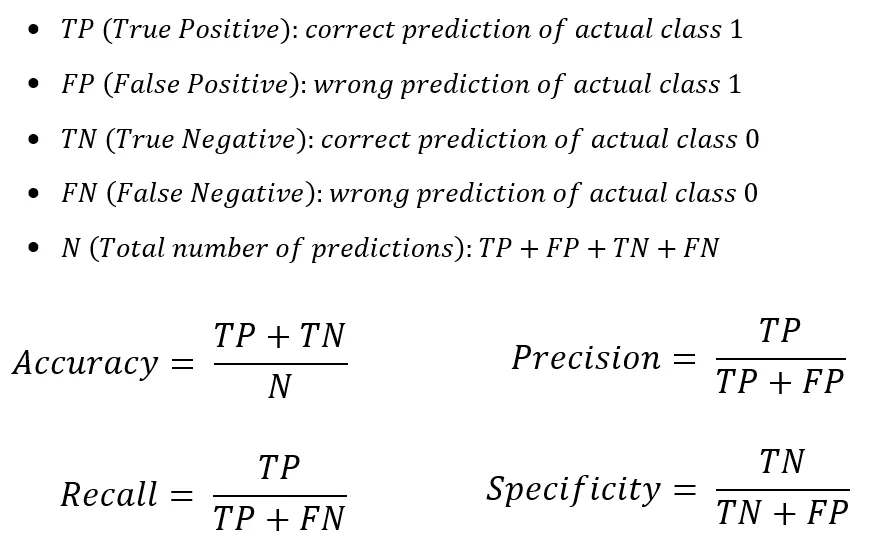

In [ ]:
def b_tp(preds, labels):
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  preds = np.argmax(preds, axis=1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  fp = b_fp(preds, labels)
  tn = b_tn(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'

  return b_accuracy, b_precision, b_recall, b_specificity

# Optimal Hyperparameters:

The optimal hyperparameter values are task-specific, however below range of possible values work well across all tasks:

  - Batch size: 16, 32
  - Learning Rate (Adam): 5e-5, 3e-5, 2e-5
  - Number of epochs: 2, 3, 4

# BertForSequenceClassification

* transormers.BertForSequenceClassification is a BERT model with a linear layer for sentence classification (or regression) on top of the pooled output.

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 5e-5,
    eps = 1e-08
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 2

for _ in trange(epochs, desc='Epoch'):

  # Training
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    optimizer.zero_grad()

    # Forward pass
    train_output = model(
        b_input_ids,
        token_type_ids = None,
        attention_mask = b_input_mask,
        labels = b_labels
    )

    # Backward pass
    train_output.loss.backward()
    optimizer.step()

    # Update Tracking variables
    tr_loss += train_output.loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

    # Validation
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch
      with torch.no_grad():
        # Forward pass
        eval_output = model(
            b_input_ids,
            token_type_ids = None,
            attention_mask = b_input_mask,
        ) 
      logits = eval_output.logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Calculate Validation metrics
      b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
      val_accuracy.append(b_accuracy)

      if b_precision != 'nan': val_precision.append(b_precision)
      if b_recall != 'nan': val_recall.append(b_recall)
      if b_specificity != 'nan': val_specificity.append(b_specificity)

  print(f'\n\t - Train loss: {tr_loss / nb_tr_steps}')
  print(f'\t - Validation accuracy: {sum(val_accuracy) / len(val_accuracy)}')
  print(f"\t - Validation precision: {sum(val_precision) / len(val_precision) if len(val_precision) > 0 else 'NaN'}")
  print(f"\t - Validation recall: {sum(val_recall) / len(val_recall) if len(val_recall) > 0 else 'NaN'}")
  print(f"\t - Validation specificity: {sum(val_specificity) / len(val_specificity) if len(val_specificity) > 0 else 'NaN'}")

Epoch:  50%|█████     | 1/2 [10:53<10:53, 653.14s/it]


	 - Train loss: 0.0808086984492104
	 - Validation accuracy: 0.9857142857142858
	 - Validation precision: 0.9959016393442623
	 - Validation recall: 0.9087301587301587
	 - Validation specificity: 0.9989010989010989


Epoch: 100%|██████████| 2/2 [22:02<00:00, 661.24s/it]


	 - Train loss: 0.022624027221501173
	 - Validation accuracy: 0.9866071428571429
	 - Validation precision: 0.9738095238095238
	 - Validation recall: 0.9383597883597884
	 - Validation specificity: 0.9956272893772893


In [ ]:
new_sentence = 'WINNER!! As a valued network customer you have been selected to recieve a £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.'

test_ids = []
test_attention_mask = []

encoding = preprocessing(new_sentence, tokenizer)

test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim=0)
test_attention_mask = torch.cat(test_attention_mask, dim=0)

with torch.no_grad():
  output = model(
      test_ids.to(device),
      token_type_ids = None,
      attention_mask = test_attention_mask.to(device)
  )

prediction = 'Spam' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Ham'

print(f"Input Sentence : {new_sentence}")
print(f"Predicted Class : {prediction}")

Input Sentence : WINNER!! As a valued network customer you have been selected to recieve a £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
Predicted Class : Spam
